# MNIST Digit Classifier

In [1]:
# This cell assumes a project structure of: project-root/src/experiments/this_notebook.ipynb
# We append the parent directory to the system path, so now we can import modules from src
# We also create a variable named path which points to the project root.

import sys
from pathlib import Path

sys.path.append("../") # go to parent dir
path =  str(Path().resolve().parent.parent)

print(path)


/workspaces/Kaggle-Knowledge-Competitions


Class of configurations (consider using Hydra for heavier workloads in future):

In [2]:
from dataclasses import dataclass

@dataclass
class Configurations:
    data_dir: str = path + "/data/kaggle_mnist"
    batch_size: int = 128
    num_workers: int = 4

    lr: float = 0.01

    num_epochs: int = 5

    device: str = "cuda"
    log_dir: str = path + "/logs/torch-digit-classifier"
    log_every_n_steps: int = 50

cfg = Configurations()

In [11]:
import torch
import os
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard.writer import SummaryWriter

from trainer.digit_classifier_trainer import train_digit_classifier
from datasets.kaggle_mnist import KaggleMNIST
from models.digit_classifier import ResNet18

import socket
from datetime import datetime
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join(
                cfg.log_dir, current_time + '_' + socket.gethostname())

device = torch.device(cfg.device)
model = ResNet18(in_channels=1, out_classes=10)
data = KaggleMNIST(data_dir=cfg.data_dir, train=True, transform=None)
optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr)
logger = SummaryWriter(log_dir=log_dir)
profiler = torch.profiler.profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(log_dir),
    record_shapes=True,
    profile_memory=True,
    with_flops=True,
    with_stack=True)

n_val = int(len(data) * 0.2)
n_train = len(data) - n_val
train_data, val_data = random_split(data, [n_train, n_val])

train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
)

val_loader = DataLoader(
    val_data,
    shuffle=False,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
)

train_digit_classifier(
    model,
    train_loader,
    val_loader,
    num_epochs=cfg.num_epochs,
    device=device,
    optimizer=optimizer,
    logger=logger,
    log_every_n_steps=cfg.log_every_n_steps,
    profiler=profiler,
)

Epoch 4: val: 100%|██████████| 66/66 [00:00<00:00, 92.16it/s] 


In [4]:
from trainer.digit_classifier_trainer import test_digit_classifier

data = KaggleMNIST(data_dir=cfg.data_dir, train=False, transform=None)
test_loader = DataLoader(
    data,
    shuffle=False,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
)

raw_preds = test_digit_classifier(model, test_loader, device)

Generating predictions on test set: 100%|██████████| 219/219 [00:01<00:00, 201.79it/s]


Our raw prediction is currently a list of tuples representing the predictions for each batch. We want to turn this into two tensors, each the length of the test set.

In [5]:
def unpack_predictions(predictions):
    """Takes the output of trainer.predict and unpacks it into a tuple of two tensors
    over the data set:
        (imgs, predictions)
    """
    # predictions start as list of tuples (img tensor, pred_tensor), of length num_batches.
    # each tensor is 1D with length batch_size.
    # we want to convert this to two tensors which are the length of the val/test set.
    unpacked_imgs = torch.Tensor().to(predictions[0][0].device)
    unpacked_predictions = torch.Tensor().to(predictions[0][0].device)
    for batch in predictions:
        imgs, preds = batch
        unpacked_predictions = torch.cat([unpacked_predictions, preds], dim=0)
        unpacked_imgs = torch.cat([unpacked_imgs, imgs], dim=0)

    return  unpacked_imgs, unpacked_predictions

predictions = unpack_predictions(raw_preds)

Now, lets sanity check our predictions to see if they're reasonable:

1
8
5
4
9
2
9
2
0
5


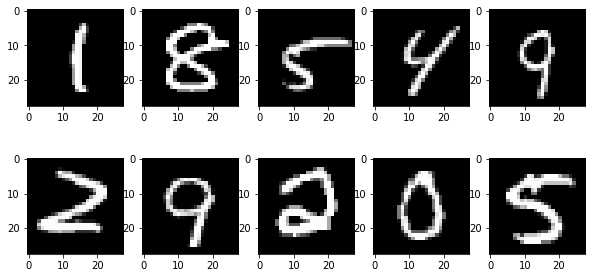

In [6]:
import matplotlib.pyplot as plt
import random

imgs, preds = predictions
imgs = imgs.squeeze().detach().cpu().numpy()
preds = preds.int().squeeze().detach().cpu().numpy()

nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10,5))

for i in range(nrows):
    for j in range(ncols):
        k = random.randint(0,28000)
        axs[i,j].imshow(imgs[k],cmap="gray")
        print(preds[k])


Finally, save our predictions in the format for Kaggle submission. You can submit by running the following line:
```bash
# submits preds.csv to the mnist classification competition
kaggle competitions submit -c digit-recognizer -f data/kaggle_mnist/preds.csv --message first_submission_with_api
```

In [7]:
import pandas as pd
df = pd.DataFrame({"ImageId" : list(range(1, 28001)),"Label" : preds})
df.to_csv(path+"/data/kaggle_mnist/preds.csv", index=False)